# CM3070 - Final Project
## CM3015- Template 1: Deep Learning on a public dataset  

For this project we will use the dataset provided by Kaggle in the competition [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/) and the the FastAI library.

In [1]:
from fastai.vision.all import *

In [2]:
image_type = 'jpg'

The `train_v2.csv` has the filenames and the labels, each image can have multiple labels.

In [3]:
train_label = pd.read_csv('datasets/train/train_v2.csv')

Because the second column has the labels separated by a blank space we use the `label_delim` parameter, the `bs` parameter change the batch size to fit in the video card memmory.

In [4]:
dls = ImageDataLoaders.from_df(train_label, folder=f'datasets/train/{image_type}/', label_delim=' ', suff='.' + image_type, bs=16)

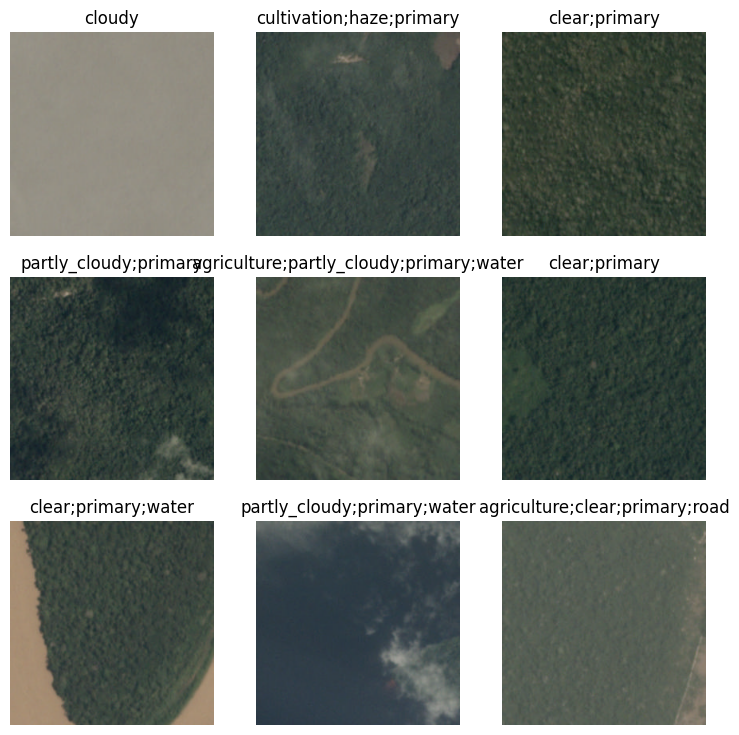

In [5]:
dls.show_batch()

## Generating the model
We will use a residual network with 50 layers in our model.

For a multilabel model the accuracy is not the best predictor because of that we will use F1 score.

In [6]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'

In [7]:
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'

In [8]:
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.001737800776027143)

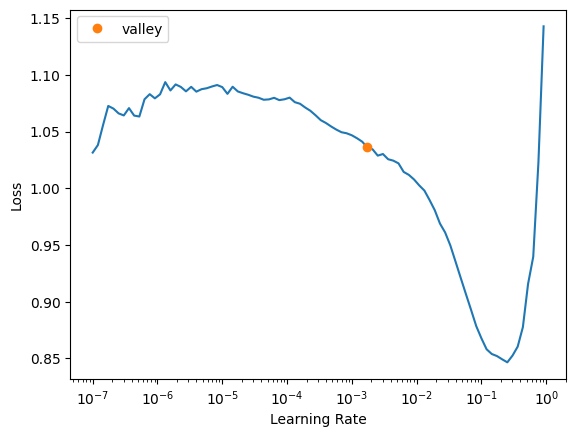

In [9]:
learn.lr_find()

For the fine tunning we will use a step of 0.002.

In [10]:
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.143405,0.118225,0.956131,0.461470,0.869204,07:32


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.113882,0.096434,0.963289,0.511981,0.891245,10:28
1,0.094461,0.088120,0.965839,0.571763,0.901161,10:28


## Model result

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


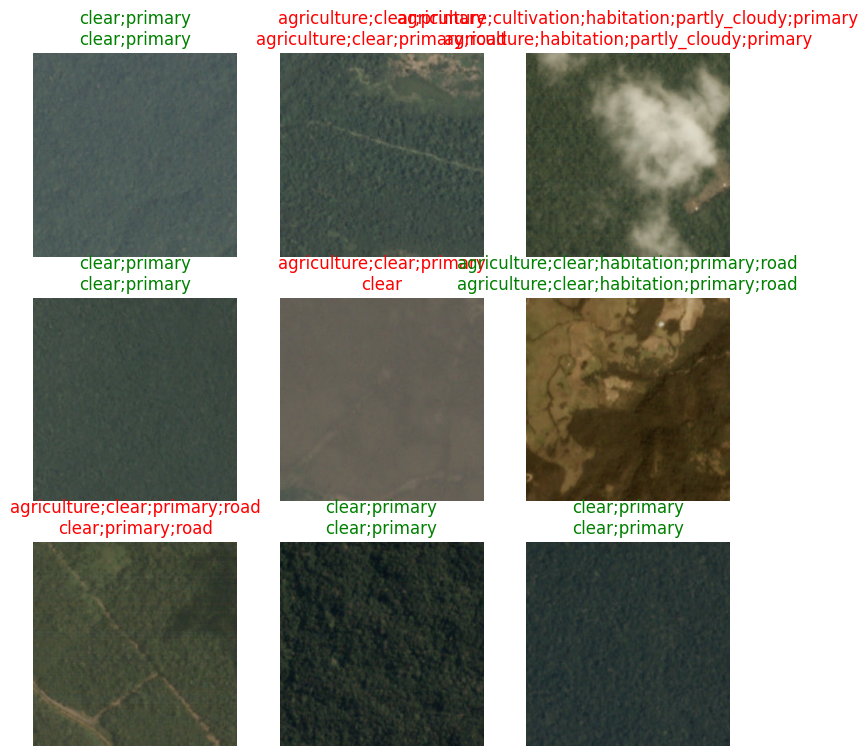

In [11]:
learn.show_results()

In [12]:
interp = Interpretation.from_learner(learn)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,agriculture;cultivation;haze;primary;road,,"tensor([1.6211e-02, 8.4498e-06, 1.7665e-03, 4.1529e-05, 1.4844e-06, 3.8280e-01,\n 3.2608e-01, 6.2302e-06, 7.7527e-04, 4.2958e-03, 3.1505e-02, 3.4062e-03,\n 1.9632e-01, 2.6517e-03, 2.3258e-05, 7.5668e-06, 3.8429e-01])",1.3926091194152832
1,agriculture;artisinal_mine;clear;conventional_mine;cultivation;habitation;primary;road;water,artisinal_mine;clear;primary;water,"tensor([1.2856e-02, 9.9980e-01, 1.0831e-01, 2.0325e-04, 2.1139e-06, 9.9763e-01,\n 2.8070e-04, 2.3471e-03, 1.4620e-02, 5.3989e-02, 6.0988e-04, 2.3111e-04,\n 9.8564e-01, 3.6474e-01, 2.1747e-03, 1.2310e-05, 9.3897e-01])",1.1035064458847046
2,conventional_mine;haze;primary;road,agriculture;clear;habitation;primary,"tensor([6.7900e-01, 7.6305e-04, 2.4407e-02, 5.1252e-04, 9.4896e-05, 9.6938e-01,\n 2.3700e-04, 8.3411e-04, 1.0540e-01, 8.5000e-01, 2.7681e-02, 1.0339e-02,\n 9.8951e-01, 4.9269e-01, 3.2893e-04, 9.5839e-04, 4.5288e-01])",1.0980229377746582
3,agriculture;habitation;partly_cloudy;primary;road,cloudy,"tensor([3.9089e-02, 3.6499e-05, 1.6325e-03, 2.8675e-04, 6.6394e-05, 1.7831e-02,\n 7.7768e-01, 3.7619e-05, 3.9805e-03, 4.1556e-03, 1.5409e-02, 1.5538e-01,\n 1.8235e-01, 2.2391e-02, 8.6364e-05, 3.8096e-05, 2.9639e-02])",1.0389081239700317
4,agriculture;blooming;clear;cultivation;habitation;primary,clear;primary,"tensor([9.6691e-03, 8.0926e-05, 1.3555e-03, 9.6715e-02, 6.4206e-04, 9.9901e-01,\n 1.9849e-04, 3.2578e-05, 7.8333e-03, 1.7809e-02, 1.1643e-03, 5.4155e-04,\n 9.9954e-01, 2.8375e-03, 1.1103e-02, 1.8912e-04, 2.3702e-03])",0.9337790012359619
5,agriculture;bare_ground;haze,bare_ground;clear;primary,"tensor([1.8994e-01, 2.4015e-02, 9.1602e-01, 2.8746e-04, 1.3186e-04, 9.9597e-01,\n 5.0190e-04, 2.2627e-03, 7.2811e-03, 7.6613e-02, 1.8592e-03, 9.6154e-04,\n 5.2624e-01, 3.6784e-01, 7.1712e-04, 1.8857e-04, 9.8562e-02])",0.8809516429901123
6,agriculture;habitation;partly_cloudy;primary;road;water,agriculture;clear;habitation;primary;road,"tensor([9.6830e-01, 2.2114e-05, 3.6660e-03, 4.2560e-05, 2.8537e-05, 9.9693e-01,\n 3.2217e-05, 4.6965e-05, 7.1494e-02, 5.7387e-01, 1.1633e-03, 2.8363e-03,\n 9.9412e-01, 9.6206e-01, 1.3477e-04, 4.1026e-04, 8.0047e-02])",0.8756994605064392
7,cloudy,partly_cloudy;primary;water,"tensor([4.1933e-01, 2.5098e-04, 4.3693e-03, 1.4748e-05, 8.1018e-06, 2.5341e-03,\n 5.3371e-03, 4.7300e-05, 3.2023e-02, 5.0983e-03, 5.3323e-03, 9.8660e-01,\n 9.4191e-01, 4.3992e-02, 4.5301e-05, 1.8875e-04, 7.9202e-01])",0.8588559627532959
8,agriculture;partly_cloudy;primary;road,agriculture;clear;primary;water,"tensor([7.4605e-01, 3.6492e-04, 1.8517e-02, 3.1721e-04, 4.7077e-05, 9.5727e-01,\n 3.2729e-04, 1.9556e-04, 2.5842e-01, 5.9463e-02, 1.4940e-02, 9.5199e-03,\n 9.9793e-01, 4.6653e-02, 1.5156e-04, 2.6040e-03, 9.4105e-01])",0.8468410968780518


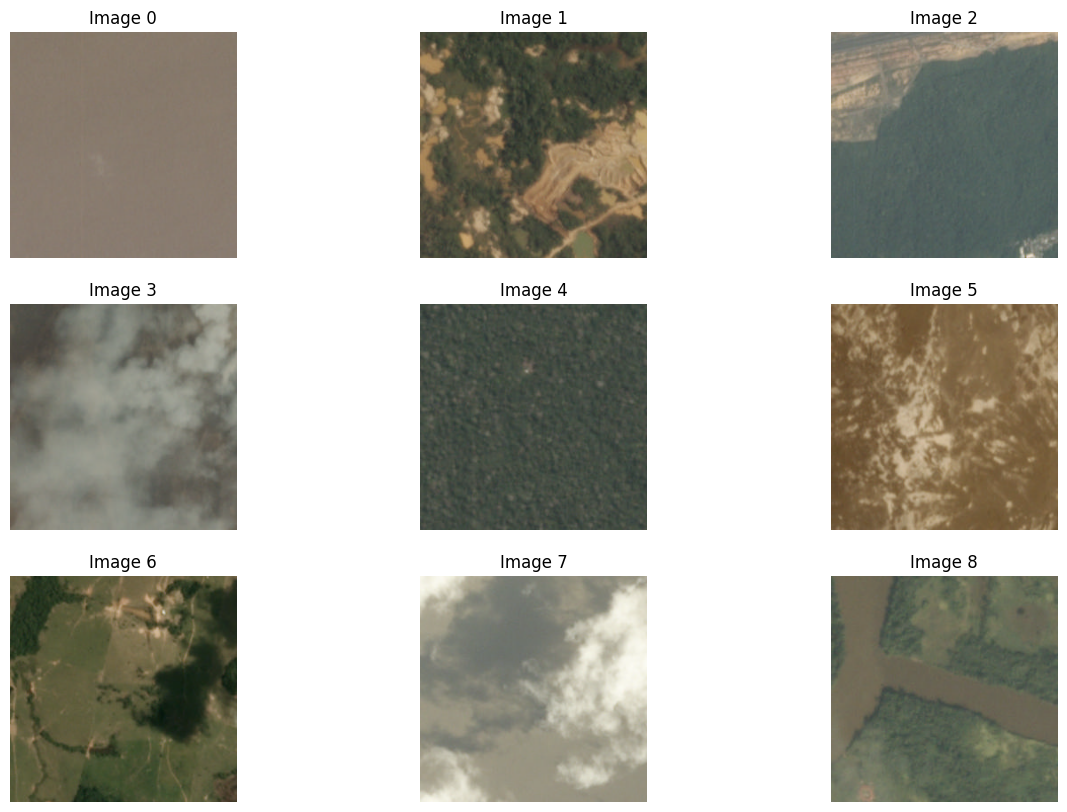

In [13]:
interp.plot_top_losses(9, figsize=(15,10))

## Sample prediction

In [14]:
learn.predict('datasets/train/jpg/train_0.jpg')

((#2) ['haze','primary'],
 tensor([False, False, False, False, False, False, False, False, False, False,
          True, False,  True, False, False, False, False]),
 tensor([1.8344e-03, 6.9678e-06, 3.6960e-04, 7.8131e-04, 3.1688e-06, 3.5200e-01,
         5.6375e-04, 3.3795e-06, 2.4941e-03, 2.1443e-04, 6.4467e-01, 1.2736e-03,
         9.9875e-01, 4.4611e-04, 9.8260e-05, 1.5949e-05, 3.1670e-03]))

## Saving the model for future use

In [15]:
learn.save('multi-rn50')

Path('models/multi-rn50.pth')

In [16]:
torch.save(learn.model, "models/multi-rn50.pt") 

## Predicting the test dataset
For the competition 64k images were provided, now we will predict these images and save the result to a `csv` file to be send to Kaggle.

In [17]:
test_files = get_image_files('datasets/test/jpg')

In [18]:
test_dl = learn.dls.test_dl(test_files)

In [19]:
probs, _ = learn.get_preds(dl=test_dl)

In [20]:
threshold = 0.5

In [21]:
preds = (probs > threshold).numpy()

In [22]:
label_names = learn.dls.vocab

In [23]:
predicted_labels = [' '.join(label_names[pred]) for pred in preds.astype(bool)]

In [24]:
df = pd.DataFrame({
    'image_name': [f.name.split('.')[0] for f in test_files],
    'tags': predicted_labels
})

In [25]:
df.to_csv('predictions.csv', index=False)

## Kaggle result
With this model I achieved a score of 0.89074.
![leaderboard](leaderboard.png)